In [1]:
import os

N_THREADS = "4"
os.environ["OMP_NUM_THREADS"] = N_THREADS
os.environ["OPENBLAS_NUM_THREADS"] = N_THREADS
os.environ["MKL_NUM_THREADS"] = N_THREADS
os.environ["VECLIB_MAXIMUM_THREADS"] = N_THREADS
os.environ["NUMEXPR_NUM_THREADS"] = N_THREADS

import gEconpy as ge
import numpy as np
import pandas as pd
import gEconpy.plotting as gp
import matplotlib.pyplot as plt
import arviz as az
from corner import corner

import pymc as pm
from pymc.model.transform.optimization import freeze_dims_and_data

import preliz as pz
import nutpie as ntp

In [2]:
gcn_file = "../GCN Files/sims_2024/nk_taylor_rule_capital.gcn"
mod = ge.model_from_gcn(gcn_file)

Model Building Complete.
Found:
	21 equations
	21 variables
		The following variables were eliminated at user request:
			D_t, TC_t, T_t, U_t, Y_j_t
		The following "variables" were defined as constants and have been substituted away:
			B_t
	4 stochastic shocks
		 0 / 4 has a defined prior. 
	16 parameters
		 15 / 16 parameters has a defined prior. 
	0 parameters to calibrate.
Model appears well defined and ready to proceed to solving.



In [3]:
ge.check_steady_state(mod)

Steady state successfully found!


In [4]:
pi_bar_values = np.linspace(-0.005, 0.01, 100)
ss_pi_bar = pd.DataFrame(
    [mod.steady_state(pi_bar=1 + pi_bar, sigma=1.0) for pi_bar in pi_bar_values],
    index=pi_bar_values,
)

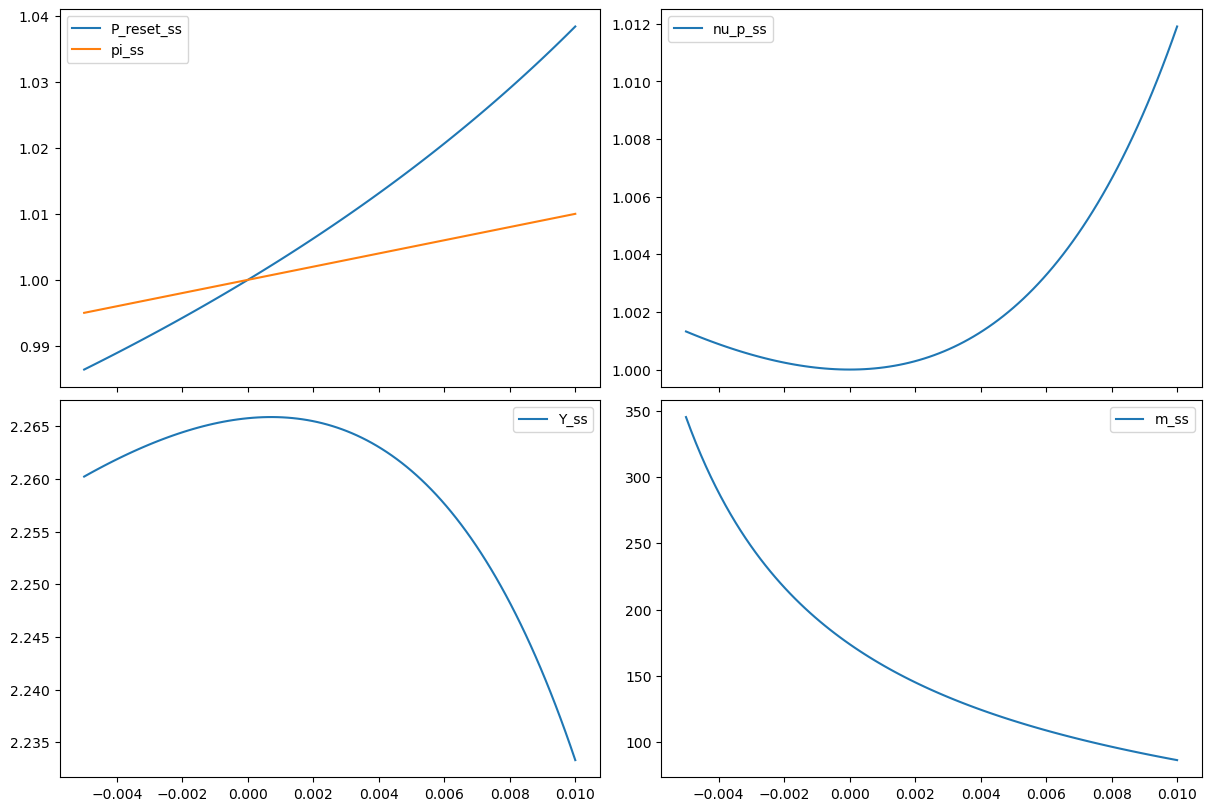

In [5]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(2, 2, figsize=(12, 8), sharex=True, layout="constrained")
variables = [["P_reset_ss", "pi_ss"], ["nu_p_ss"], ["Y_ss"], ["m_ss"]]

for var, axis in zip(variables, fig.axes):
    ss_pi_bar[var].plot(ax=axis)

plt.show()

In [6]:
irf_by_phi = {
    f"phi = {phi}": ge.impulse_response_function(
        mod,
        **{"phi": phi, "pi_bar": 1.001},
        shock_size={"epsilon_A": 0.01, "epsilon_i": 0.01, "epsilon_pi_obj": 0.01},
        simulation_length=20,
        not_loglin_variables=["i", "pi", "pi_obj"],
        verbose=False,
    ).isel(time=slice(1, None))
    for phi in [0, 0.75, 0.9]
}

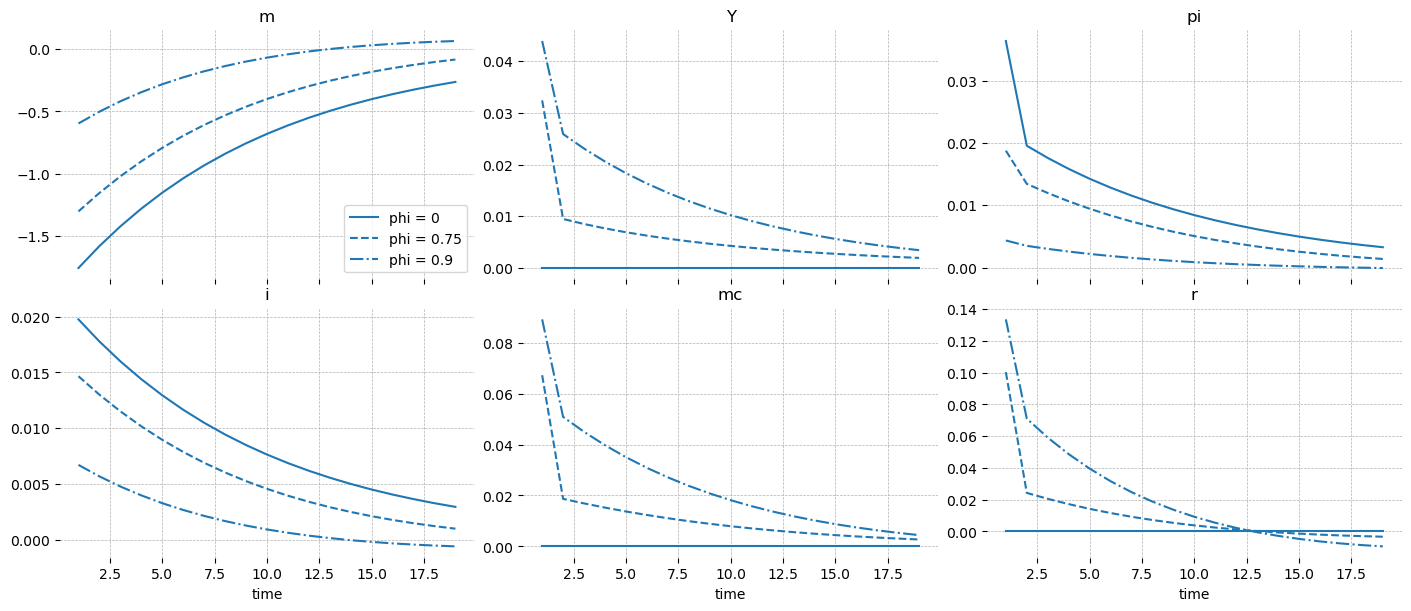

In [7]:
gp.plot_irf(
    irf_by_phi,
    vars_to_plot=["m", "Y", "pi", "i", "mc", "r"],
    shocks_to_plot=["epsilon_pi_obj"],
    n_cols=3,
    figsize=(14, 6),
);

In [8]:
ss_mod = ge.statespace_from_gcn(gcn_file, not_loglin_variables=["i", "pi", "pi_obj"])

Model Building Complete.
Found:
	21 equations
	21 variables
		The following variables were eliminated at user request:
			D_t, TC_t, T_t, U_t, Y_j_t
		The following "variables" were defined as constants and have been substituted away:
			B_t
	4 stochastic shocks
		 0 / 4 has a defined prior. 
	16 parameters
		 15 / 16 parameters has a defined prior. 
	0 parameters to calibrate.
Model appears well defined and ready to proceed to solving.

Statespace model construction complete, but call the .configure method to finalize.


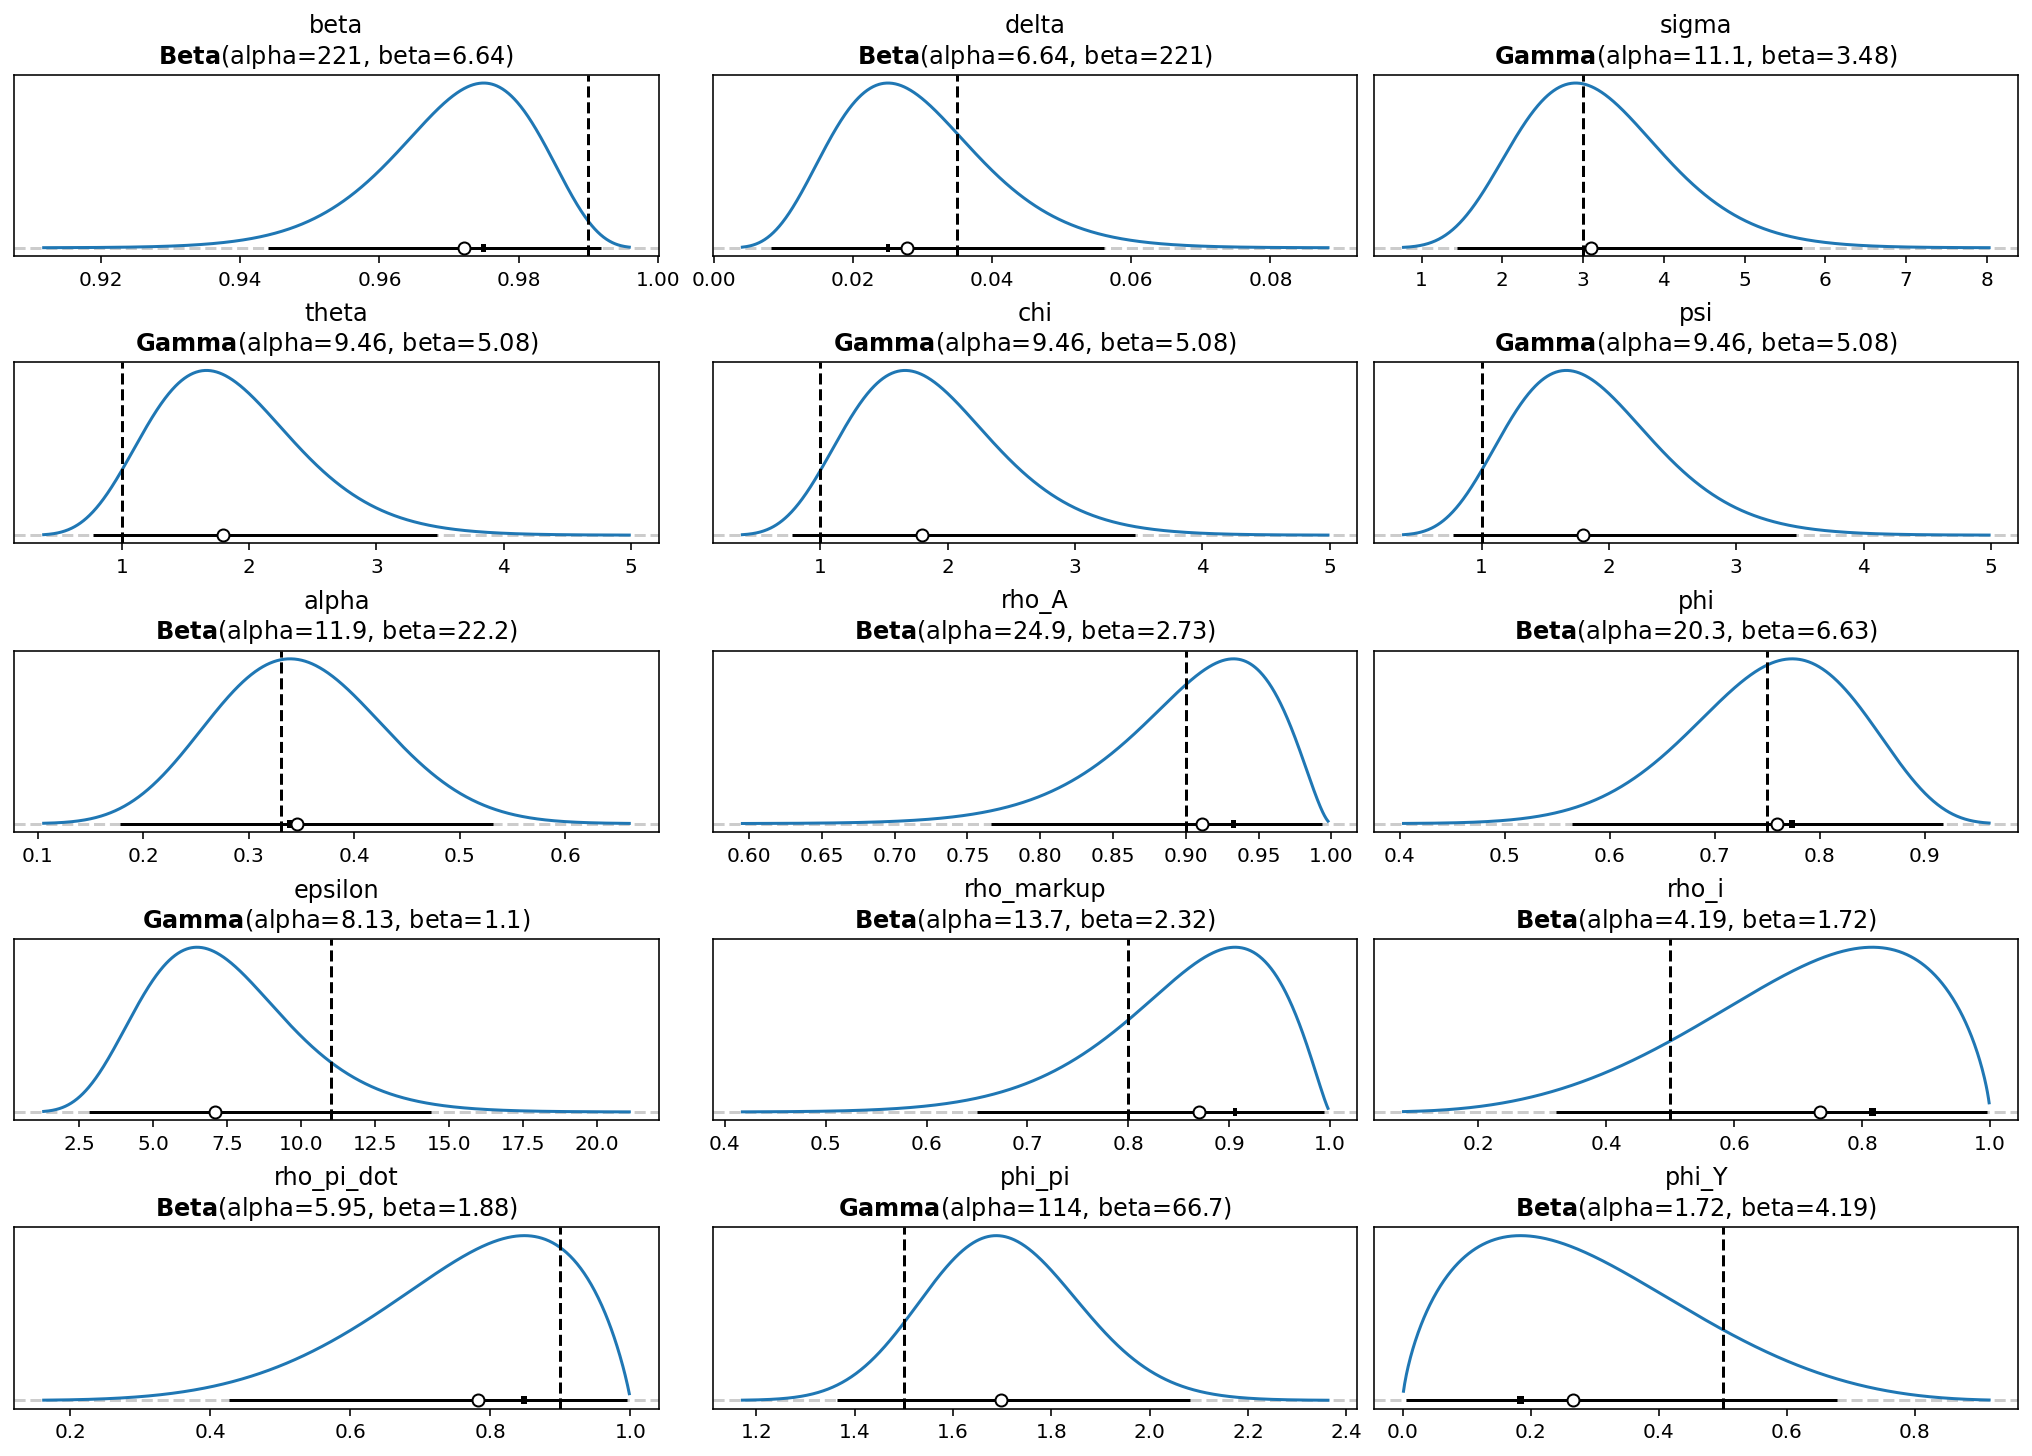

In [9]:
gp.plot_priors(ss_mod, n_cols=3);

In [10]:
ss_mod.configure(
    observed_states=["Y", "C", "I", "N", "pi", "i", "w", "m", "r"],
    measurement_error=["Y", "C", "I", "N", "w", "m", "r"],
    constant_params=["pi_bar"],
    full_shock_covaraince=True,
    solver="scan_cycle_reduction",
    mode="JAX",
    max_iter=20,
    use_adjoint_gradients=True,
)

The following parameters should be assigned priors inside a PyMC model block: 
	alpha -- shape: (), constraints: None, dims: None
	beta -- shape: (), constraints: None, dims: None
	chi -- shape: (), constraints: None, dims: None
	delta -- shape: (), constraints: None, dims: None
	epsilon -- shape: (), constraints: None, dims: None
	phi -- shape: (), constraints: None, dims: None
	phi_Y -- shape: (), constraints: None, dims: None
	phi_pi -- shape: (), constraints: None, dims: None
	psi -- shape: (), constraints: None, dims: None
	rho_A -- shape: (), constraints: None, dims: None
	rho_i -- shape: (), constraints: None, dims: None
	rho_markup -- shape: (), constraints: None, dims: None
	rho_pi_dot -- shape: (), constraints: None, dims: None
	sigma -- shape: (), constraints: Positive, dims: None
	theta -- shape: (), constraints: None, dims: None
	state_cov -- shape: (4, 4), constraints: Positive Semi-Definite, dims: ('shock', 'shock_aux')
	error_sigma_Y -- shape: (), constraints: None, dim

In [11]:
A_params = pz.maxent(pz.Gamma(), lower=0.01, upper=0.1, plot=False).params_dict
other_params = pz.maxent(pz.Gamma(), lower=0.001, upper=0.01, plot=False).params_dict

sd_dist = pm.Gamma.dist(
    alpha=[A_params["alpha"]] + [other_params["alpha"]] * 3,
    beta=[A_params["beta"]] + [other_params["beta"]] * 3,
)

In [12]:
all_priors = ss_mod.param_priors | ss_mod.shock_priors

with pm.Model(coords=ss_mod.coords) as pm_mod:
    ss_mod.to_pymc()
    for var_name in ss_mod.error_states:
        x = pz.maxent(pz.Gamma(), lower=0.01, upper=0.05, plot=False)
        all_priors[f"error_sigma_{var_name}"] = x
        x.to_pymc(name=f"error_sigma_{var_name}")

    chol, *_ = pm.LKJCholeskyCov(
        "state_chol", n=ss_mod.k_posdef, eta=4, sd_dist=sd_dist
    )
    cov = pm.Deterministic("state_cov", chol @ chol.T, dims=["shock", "shock_aux"])

In [13]:
date_range = pd.date_range(start="1980-01-01", end="2024-11-01", freq="QS-OCT")
true_params, data, prior_idata = ge.data_from_prior(
    ss_mod, pm_mod, index=date_range, n_samples=500, pct_missing=0.01
)

/Users/jessegrabowski/mambaforge/envs/geconpy-dev/lib/python3.12/site-packages/pymc_extras/statespace/utils/data_tools.py:159: ImputationWarning: Provided data contains missing values and will be automatically imputed as hidden states during Kalman filtering.
  warnings.warn(impute_message, ImputationWarning)
Sampling: [alpha, beta, chi, delta, epsilon, error_sigma_C, error_sigma_I, error_sigma_N, error_sigma_Y, error_sigma_m, error_sigma_r, error_sigma_w, obs, phi, phi_Y, phi_pi, psi, rho_A, rho_i, rho_markup, rho_pi_dot, sigma, state_chol, theta]
Sampling: [prior_combined]


Output()

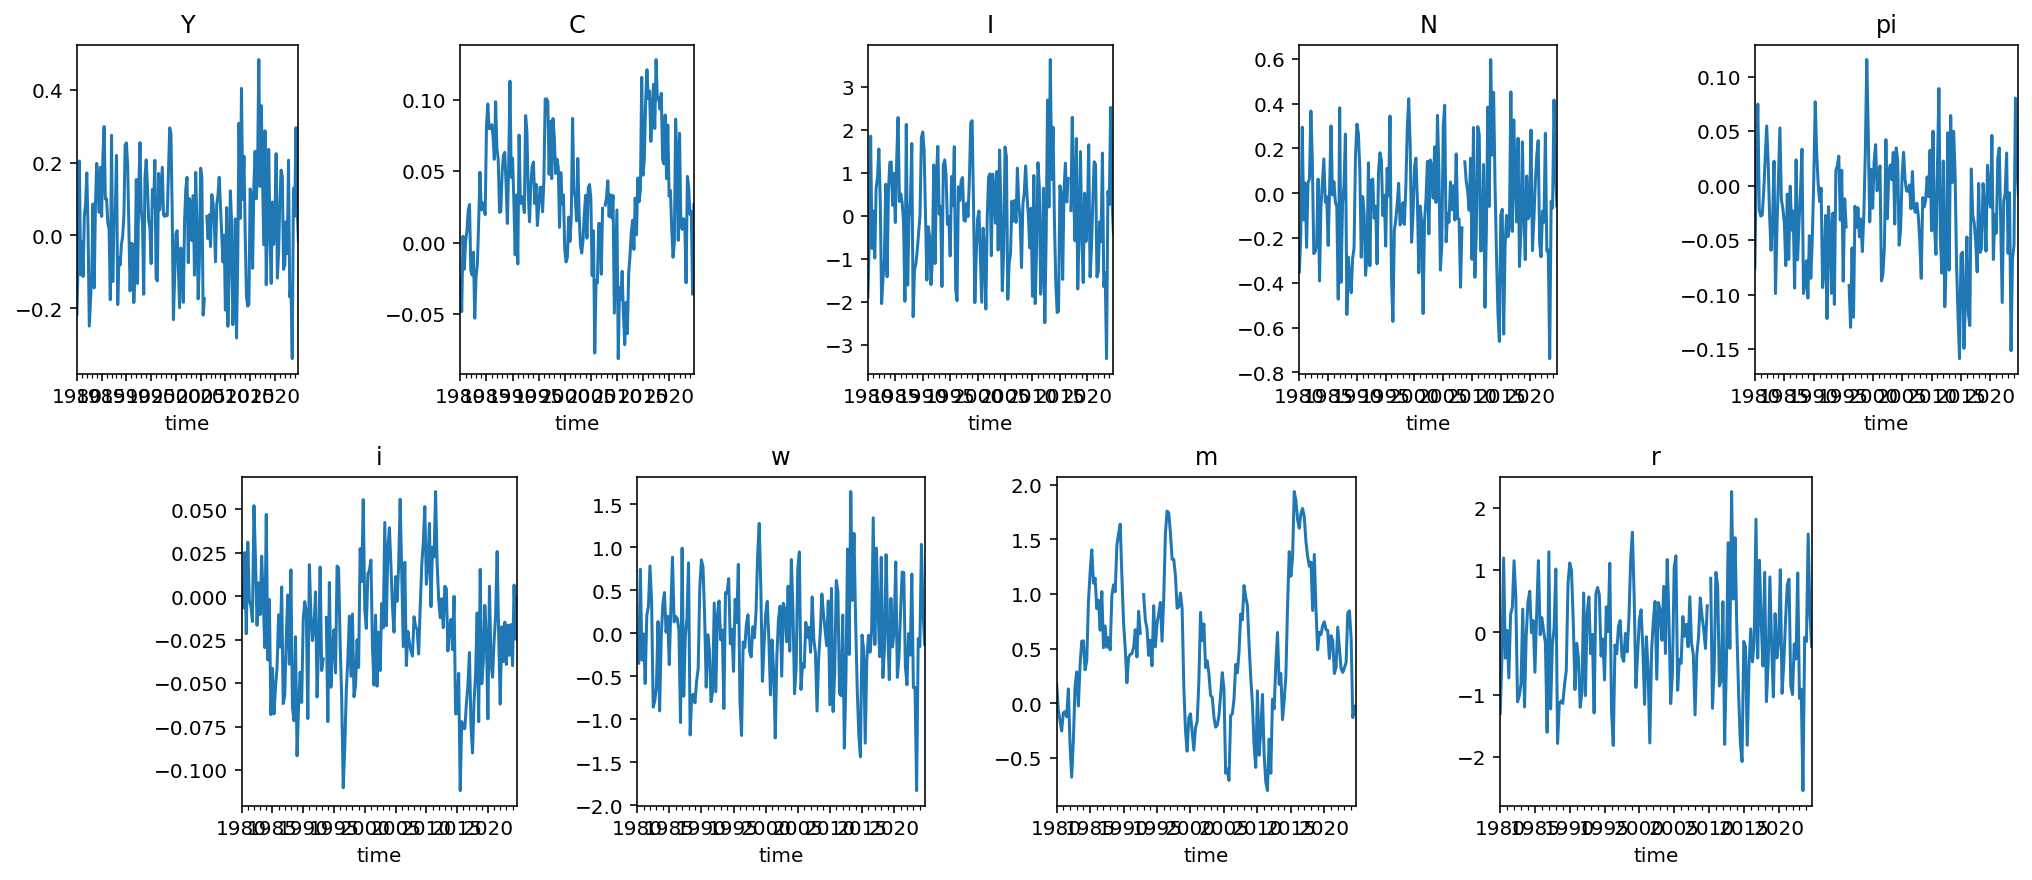

In [14]:
fig = plt.figure(figsize=(14, 6), dpi=144, layout="constrained")
gs, locs = gp.prepare_gridspec_figure(
    n_plots=len(ss_mod.observed_states), n_cols=5, figure=fig
)
for loc, col in zip(locs, data):
    axis = fig.add_subplot(gs[loc])
    data[col].plot(ax=axis, legend=False, title=col)

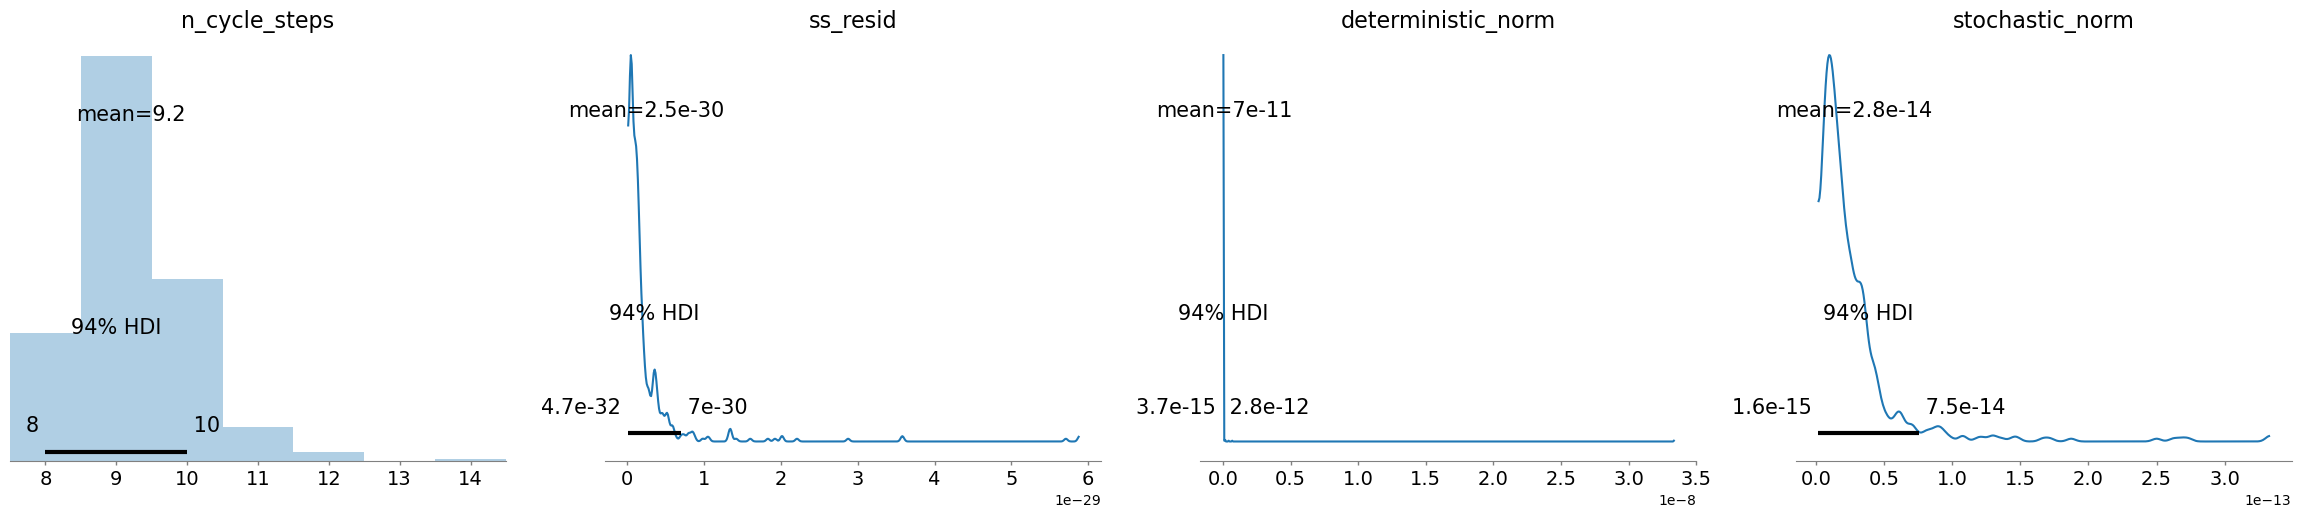

In [15]:
az.plot_posterior(
    prior_idata.prior,
    var_names=["n_cycle_steps", "ss_resid", "deterministic_norm", "stochastic_norm"],
);

In [16]:
ntp_mod = ntp.compile_pymc_model(
    freeze_dims_and_data(pm_mod),
    backend="jax",
    gradient_backend="jax",
    default_initialization_strategy="prior",
    jitter_rvs=set(),
    initial_points=None,
)
#                                  initial_points={k: v for k, v in ss_mod.param_dict.items() if k in pm_mod})

/Users/jessegrabowski/mambaforge/envs/geconpy-dev/lib/python3.12/site-packages/pymc/pytensorf.py:1066: FutureWarning: compile_pymc was renamed to compile. Old name will be removed in a future release of PyMC
  warnings.warn(
/Users/jessegrabowski/mambaforge/envs/geconpy-dev/lib/python3.12/site-packages/pymc/pytensorf.py:1066: FutureWarning: compile_pymc was renamed to compile. Old name will be removed in a future release of PyMC
  warnings.warn(


In [17]:
idata = ntp.sample(
    ntp_mod.with_transform_adapt(
        verbose=True,
        learning_rate=1e-3,
        num_layers=50,
        #                                                 nn_width=128,
        batch_size=512,
        #                                                 initial_skip=250,
        #                                                 num_diag_windows=11,
        zero_init=False,
        dct_layer=True,
        extend_dct=True,
    ),
    tune=1500,
    draws=1000,
    chains=6,
    #                    target_accept=0.95,
    transform_adapt=True,
)

seedseed 2860341245715421409
seed 705807063262372864
seed 15480298422285142880
 6843464275765804428
seed 12729001285269961404
seed 5822794725501658969
Chain 5: Total available points: 11
seed 48913683904781682
loss from diag: 10.506647755888181
Chain 3: Total available points: 11
seed 584326060158882358
loss from diag: 8.175344344527291
Chain 4: Total available points: 11
seed 2863548824272908173
loss from diag: 7.537243030495235
Chain 5: Total available points: 21
seed 2978682076191444339
loss from diag: -1.2009452991811416
Chain 2: Total available points: 11
seed 1504694693754309496
loss from diag: 6.059709858909847
Chain 4: Total available points: 21
seed 14962923439856092063
loss from diag: 0.6541223165740807
Chain 0: Total available points: 11
seed 1924432666512560159
loss from diag: 3.33228222309718
Chain 0: Total available points: 21
seed 1438706467751241646
loss from diag: -63.70891598969853
Chain 3: Total available points: 21
seed 7387105025246644013
loss from diag: 1.77624426

Chain 3: New loss 2.2837909388099913, old loss 2.5116880888480093
Chain 0: New loss 1.7401526040216726, old loss 2.158844002616215
Chain 2: Total available points: 251
Chain 4: Total available points: 351
Chain 4: New loss 2.2075281352980496, old loss 2.483118046629289
Chain 5: Total available points: 401
Extending flow...
0.6505527635400995 [0.23808536 0.28977012 0.11942522 0.06290454 0.12223935 0.09130028
 0.24560471 0.2030269  0.12529311 0.4270478  0.1350209  0.37176145
 0.50836079 0.31868572 0.23904398 0.08709226 0.10547574 0.22465153
 0.08716042 0.08384619 0.08438674 0.09608468 0.10480854 0.1451142
 0.13713632 0.4378602  0.24905706 0.28858452 0.23248863 0.22405934
 0.65055276 0.59016751]
dct: False
Chain 2: New loss 1.0809719935906699, old loss 2.8477826616825017
Chain 5: New loss 1.8617657520364035, old loss 2.3151321373147655
Chain 3: Total available points: 351
Chain 0: Total available points: 351
Chain 3: New loss 2.4913114167781583, old loss 2.932107494891204
Chain 0: New los

Chain 1: Total available points: 501
Chain 0: New loss 1.1773249077736534, old loss 1.458690521543552
Chain 5: Total available points: 751
Chain 1: New loss 1.6813832281133123, old loss 1.8310964741254256
Chain 2: Total available points: 601
Extending flow...
0.15253607932259555 [0.09007528 0.08320341 0.14977448 0.1079462  0.08586192 0.11336325
 0.11015873 0.09258503 0.15201962 0.09341351 0.08786473 0.12476026
 0.1279425  0.11543939 0.10711264 0.15253608 0.11931933 0.10974922
 0.1110295  0.08414086 0.13180822 0.11937464 0.0949018  0.12514353
 0.12785689 0.13084689 0.14968204 0.09228526 0.13248645 0.14639948
 0.08323102 0.06164808]
dct: True
Chain 5: New loss 1.3100965443155386, old loss 1.444318548914262
Chain 4: Total available points: 701
Chain 3: Total available points: 651
Chain 0: Total available points: 701
Chain 4: New loss 1.679166090243384, old loss 1.806460748616014
Chain 2: New loss 1.332094676397611, old loss 1.8068709831334555
Chain 1: Total available points: 551
Chain 3: 

Chain 1: New loss 0.5833397298304827, old loss 1.4495567373412972
Chain 4: Total available points: 1101
Chain 0: New loss 0.8870870466366951, old loss 1.046766955211267
Chain 2: Total available points: 1001
Chain 4: New loss 1.2923572500222054, old loss 1.4535215994346704
Chain 3: Total available points: 1051
Chain 5: Total available points: 1201
Chain 2: New loss 0.8439131138267643, old loss 1.0643152815210442
Chain 3: New loss 0.9476641118159832, old loss 1.0849038530813357
Chain 1: Total available points: 851
Chain 0: Total available points: 1151
Chain 5: New loss 0.9544351560014017, old loss 1.2072122406811567
Chain 4: Total available points: 1151
Chain 1: New loss 0.7197787903907261, old loss 0.8820435799378259
Chain 0: New loss 0.8853759563646217, old loss 1.0673181094261113
Chain 3: Total available points: 1101
Chain 4: New loss 1.3571202073969566, old loss 1.596068727699633
Chain 2: Total available points: 1051
Chain 5: Total available points: 1251
Chain 3: New loss 0.882612354

<Axes: >

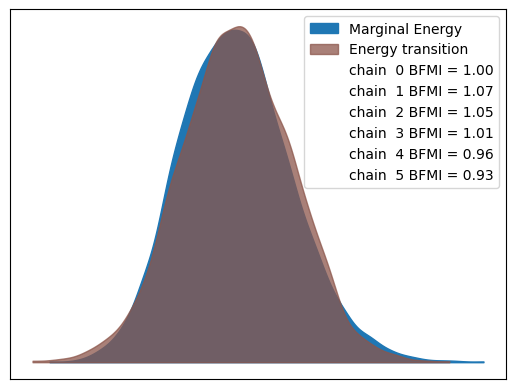

In [27]:
az.plot_energy(idata)

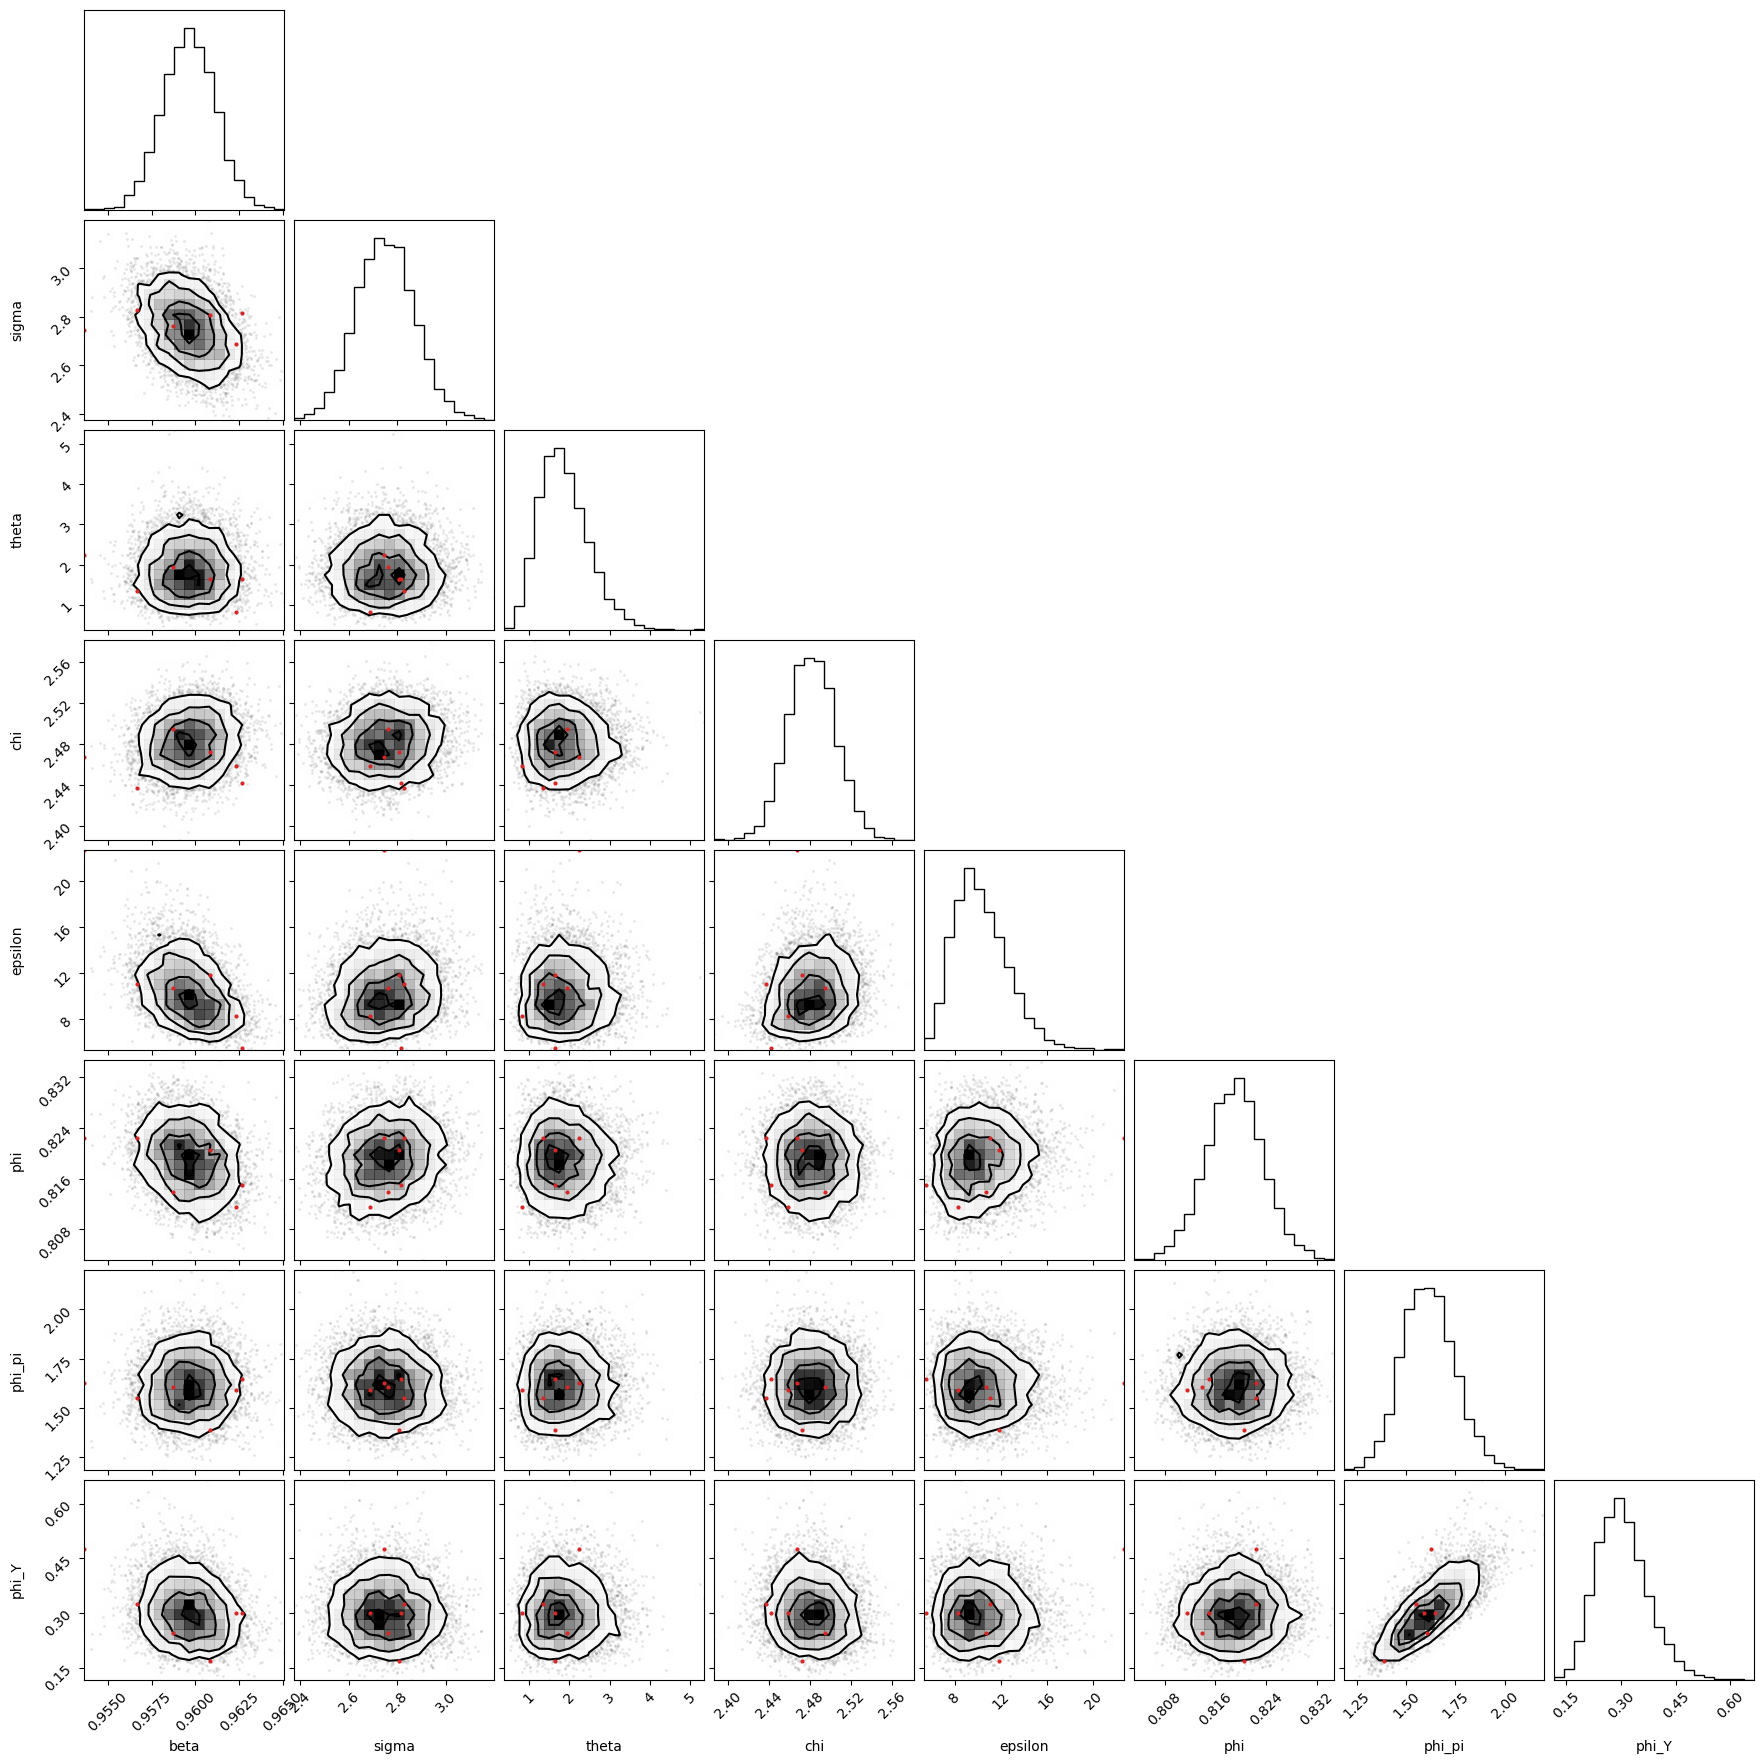

In [19]:
deep_params = ["beta", "sigma", "theta", "chi", "epsilon", "phi", "phi_pi", "phi_Y"]
var_names = [rv.name for rv in pm_mod.free_RVs]
corner(
    idata,
    var_names=deep_params,
    divergences=True,
    divergences_kwargs={"markersize": 4, "color": "tab:red"},
);

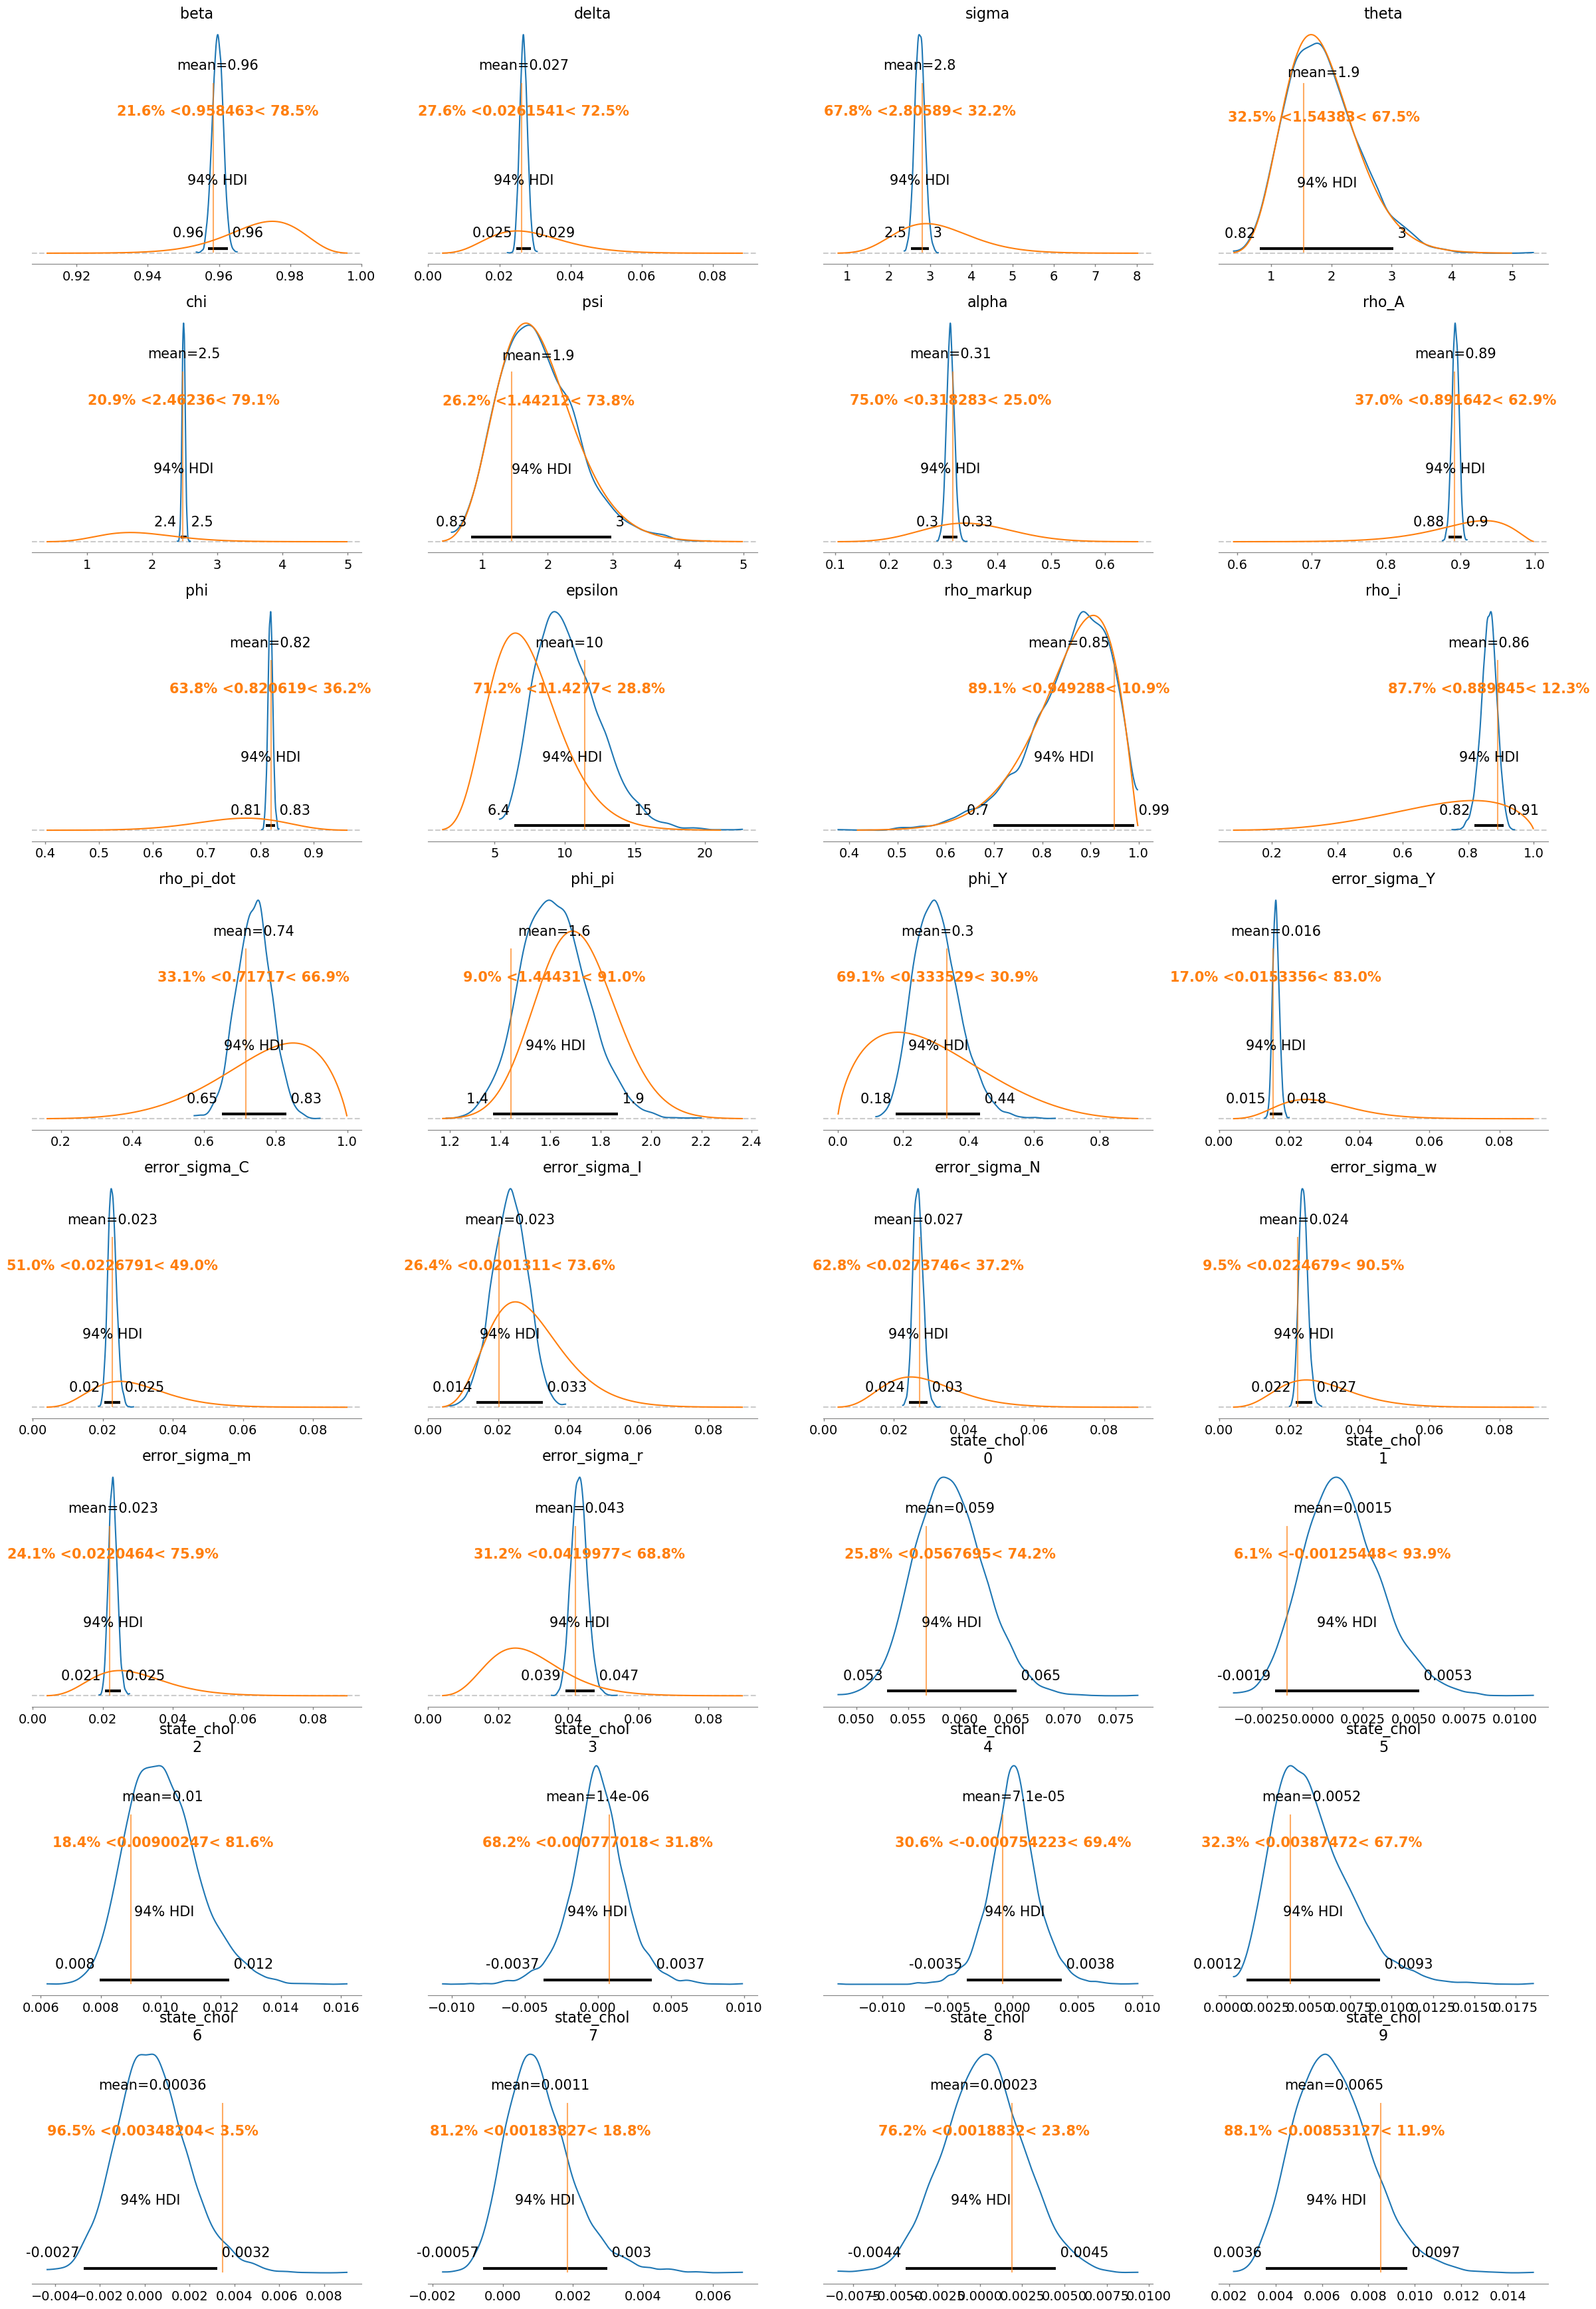

In [20]:
axes = az.plot_posterior(
    idata,
    var_names=var_names,
    ref_val=np.r_[*[true_params[name].values.ravel() for name in var_names]].tolist(),
)
for axis in axes.ravel():
    var_name, *coords = axis.get_title().split("\n")

    if var_name in all_priors:
        all_priors[var_name].plot_pdf(ax=axis, legend=False, color="tab:orange")

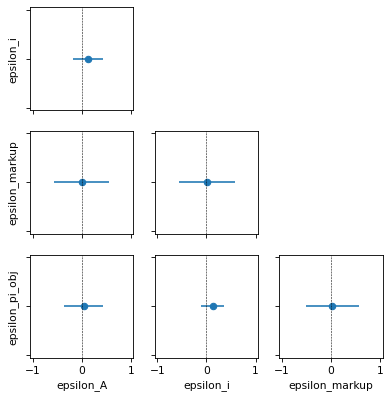

In [29]:
from itertools import product

n_shocks = ss_mod.k_posdef

fig, ax = plt.subplots(
    n_shocks,
    n_shocks,
    figsize=(8, 8),
    dpi=77,
    subplot_kw={"aspect": "equal"},
    sharex=True,
    sharey=True,
)

mu = idata.posterior.state_chol_corr.mean(dim=["chain", "draw"])
hdi = az.hdi(idata.posterior.state_chol_corr).state_chol_corr
ax[0, 0].set(xlim=(-1.05, 1.05), ylim=(-1.05, 1.05))

for i, j in product(range(n_shocks), range(n_shocks)):
    axis = ax[i, j]
    if i <= j:
        axis.set_visible(False)
        continue
    y_var = mod.shocks[i].base_name
    x_var = mod.shocks[j].base_name
    axis.scatter(mu.values[i, j], 0)
    axis.hlines(0, *hdi.values[i, j])
    axis.axvline(0, ls="--", c="k", lw=0.5)

    axis.set(
        ylabel=y_var if j == 0 else "",
        xlabel=x_var if i == (n_shocks - 1) else "",
        yticklabels=[],
    )

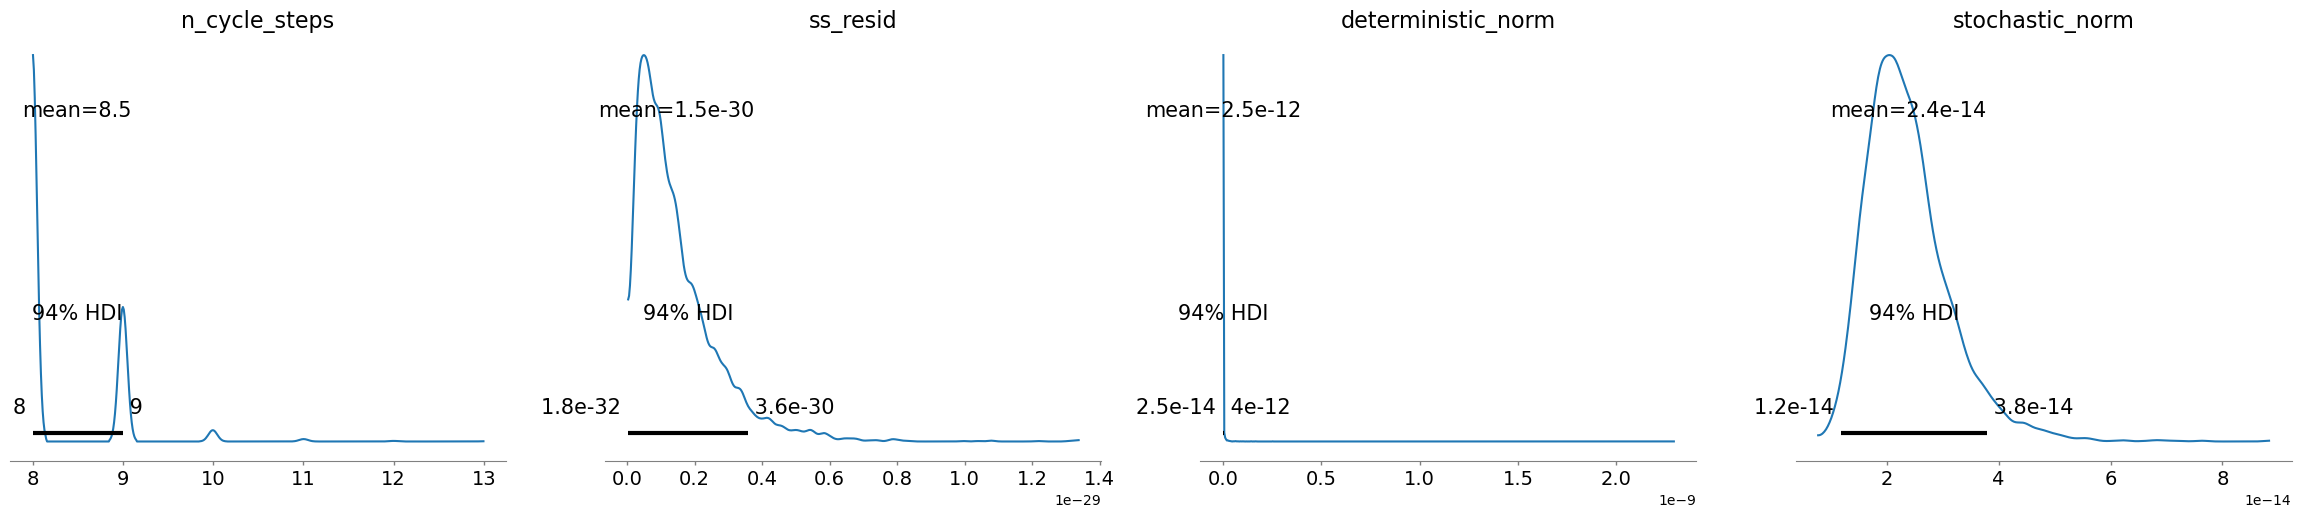

In [30]:
az.plot_posterior(
    idata,
    var_names=["n_cycle_steps", "ss_resid", "deterministic_norm", "stochastic_norm"],
);

In [22]:
cond_post = ss_mod.sample_conditional_posterior(idata)

/Users/jessegrabowski/mambaforge/envs/geconpy-dev/lib/python3.12/site-packages/pymc_extras/statespace/utils/data_tools.py:159: ImputationWarning: Provided data contains missing values and will be automatically imputed as hidden states during Kalman filtering.
  warnings.warn(impute_message, ImputationWarning)
/Users/jessegrabowski/mambaforge/envs/geconpy-dev/lib/python3.12/site-packages/pytensor/link/jax/linker.py:27: UserWarning: The RandomType SharedVariables [RNG(<Generator(PCG64) at 0x3DBC5D9A0>), RNG(<Generator(PCG64) at 0x3DBC5D1C0>), RNG(<Generator(PCG64) at 0x3DBC5C580>), RNG(<Generator(PCG64) at 0x3DBC5D7E0>), RNG(<Generator(PCG64) at 0x3DBC5D0E0>), RNG(<Generator(PCG64) at 0x3EA0C7E60>)] will not be used in the compiled JAX graph. Instead a copy will be used.
  warnings.warn(
Sampling: [filtered_posterior, filtered_posterior_observed, predicted_posterior, predicted_posterior_observed, smoothed_posterior, smoothed_posterior_observed]


Output()

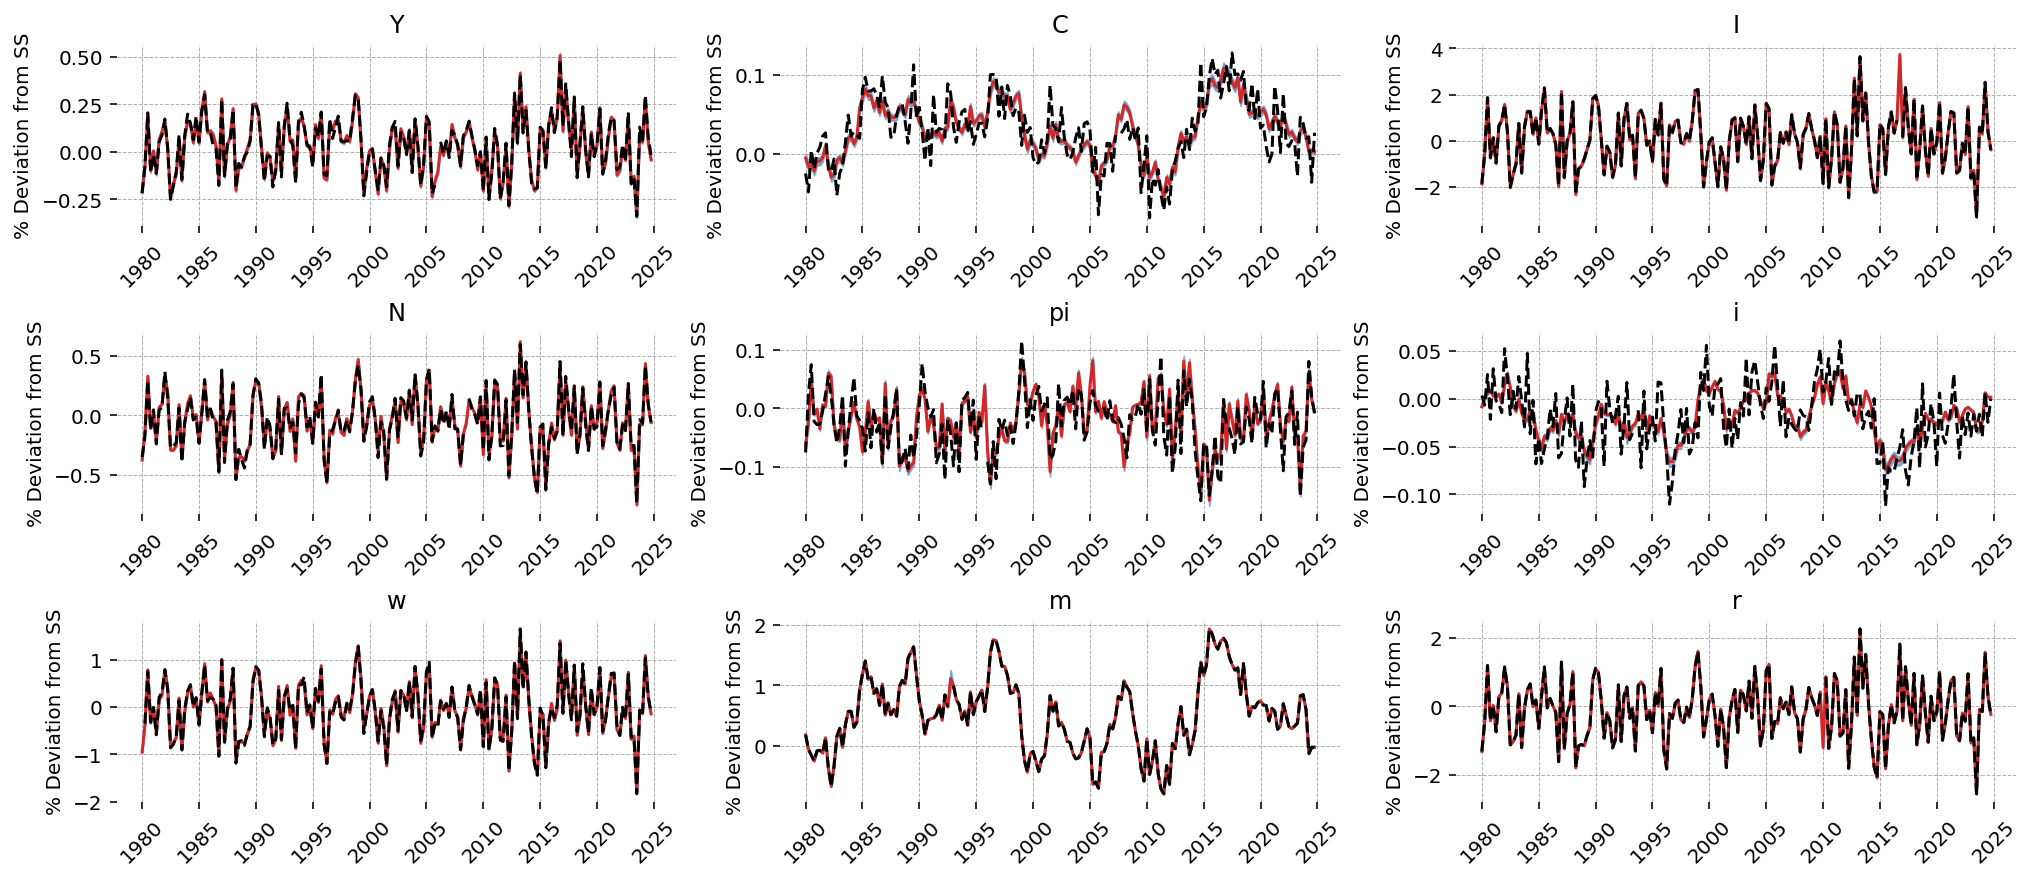

In [23]:
gp.plot_kalman_filter(
    cond_post,
    data,
    kalman_output="smoothed",
    n_cols=3,
    vars_to_plot=ss_mod.observed_states,
);

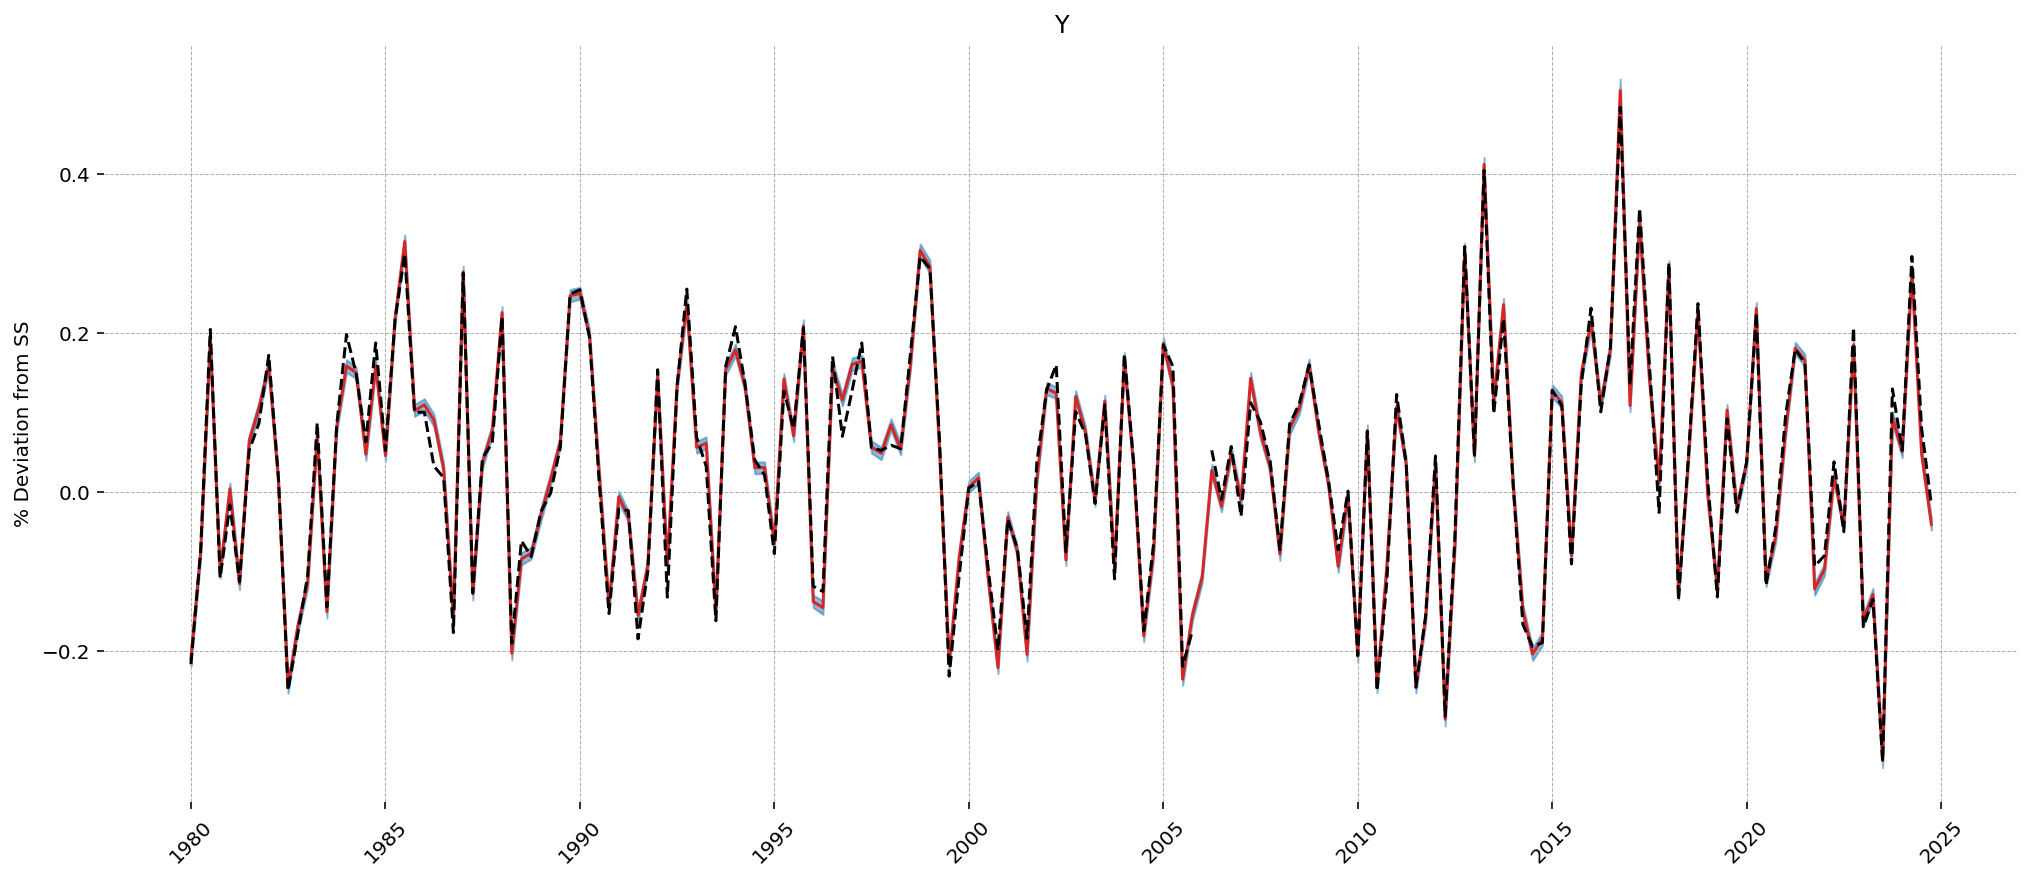

In [24]:
gp.plot_kalman_filter(
    cond_post, data, kalman_output="smoothed", n_cols=1, vars_to_plot=["Y"]
);

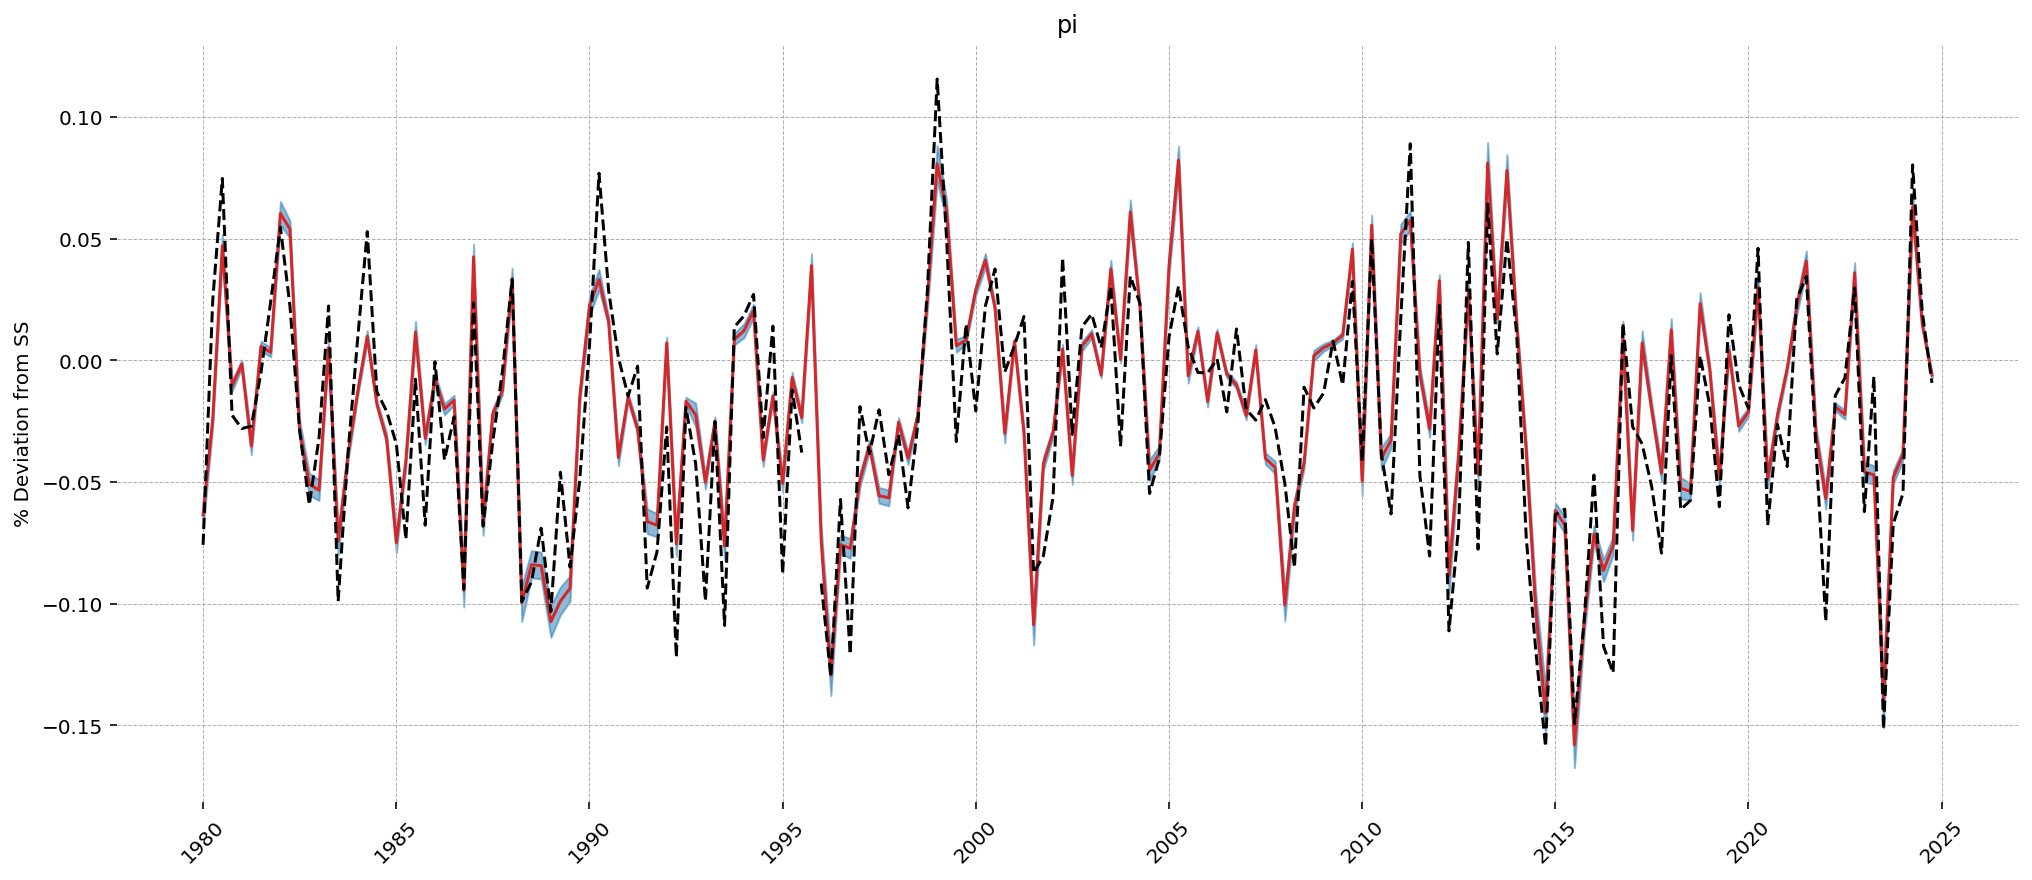

In [25]:
gp.plot_kalman_filter(
    cond_post, data, kalman_output="smoothed", n_cols=1, vars_to_plot=["pi"]
);

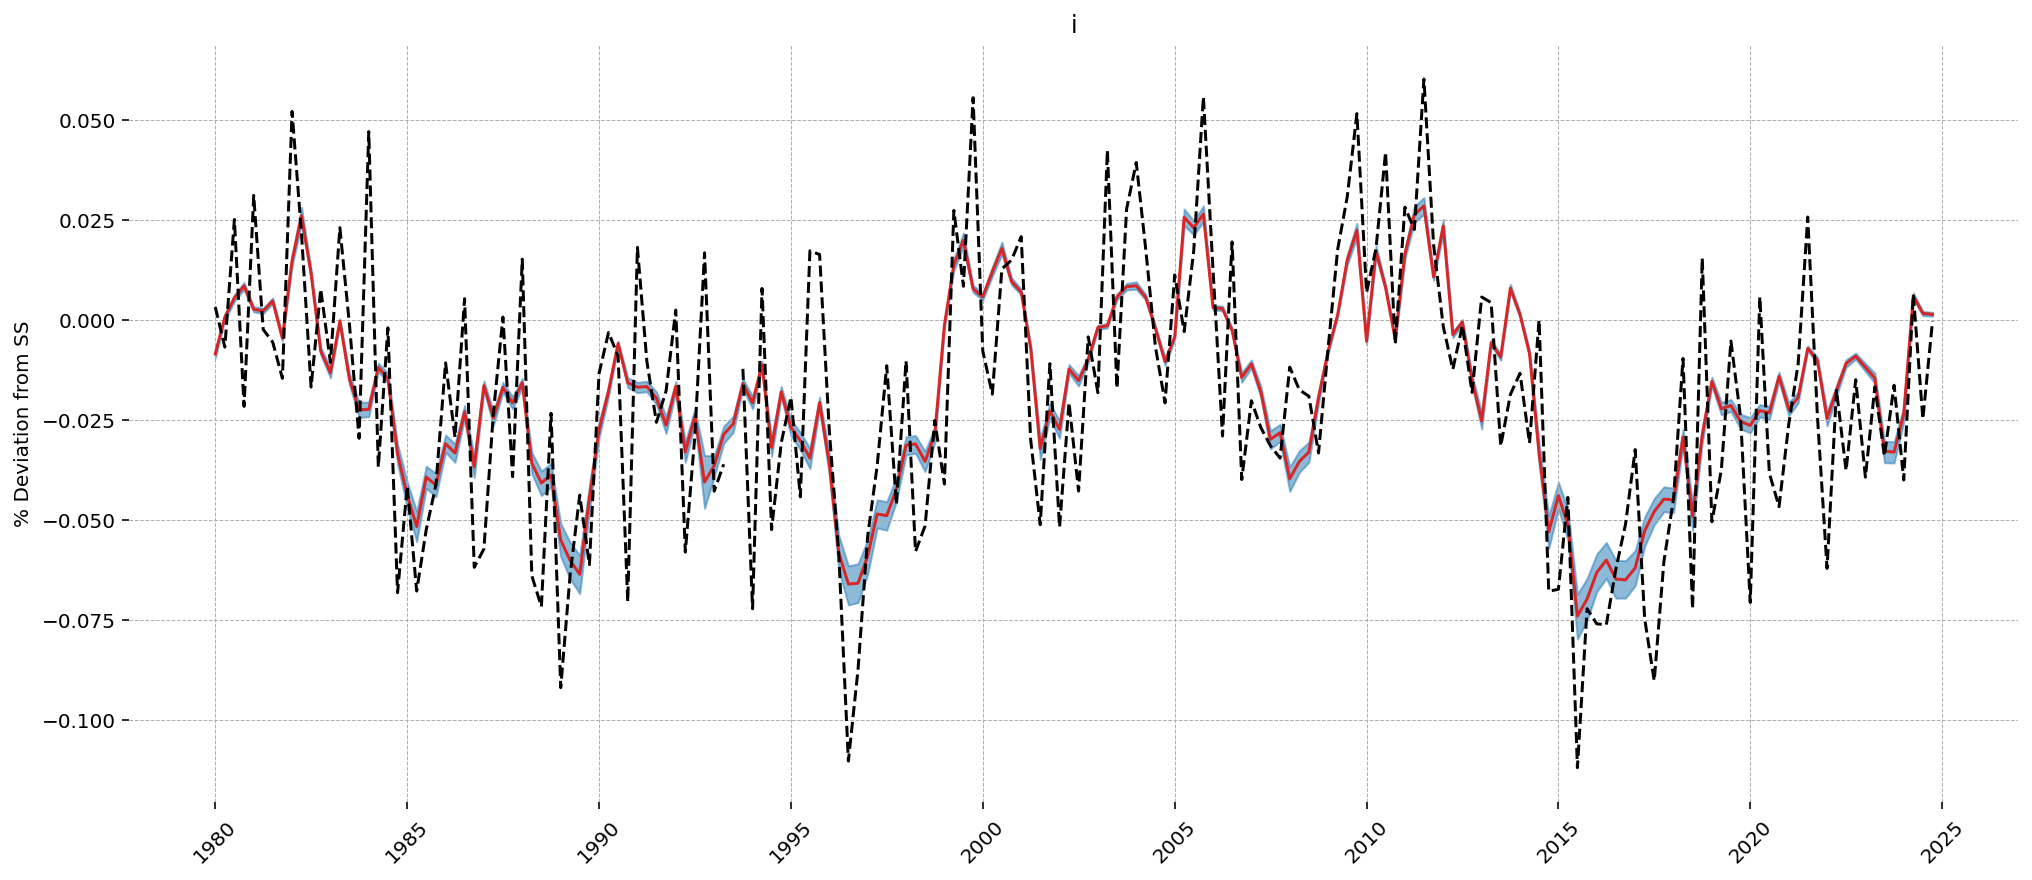

In [26]:
gp.plot_kalman_filter(
    cond_post, data, kalman_output="smoothed", n_cols=1, vars_to_plot=["i"]
);